In [4]:
from sklearn.datasets import fetch_openml
import numpy as np
import matplotlib.pyplot as plt

from RPCA import RPCA

In [6]:
mnist = fetch_openml('mnist_784')

In [90]:
indices_3 = mnist.target[mnist.target == '3'].keys()

In [91]:
mnist_3 = mnist.data.iloc[indices_3].to_numpy()

In [95]:
mnist_3_sample = mnist_3[:100]

In [97]:
X = mnist_3_sample
L,S = RPCA(X)

In [98]:
def plt_mnist(image): return plt.imshow(image.reshape(28,28),cmap=plt.cm.gray_r)

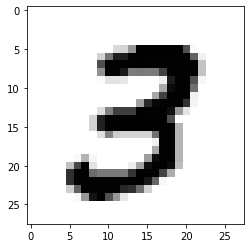

In [99]:
plt_mnist(X[0])

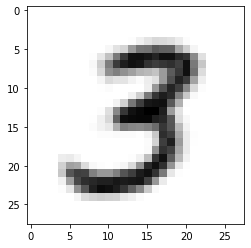

In [109]:
plt_mnist(L[0].round(3))

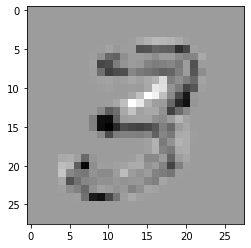

In [111]:
plt_mnist(S[0].round())

In [165]:
def mnist_subplots(X):

    plt.figure(figsize=(5, 20))

    # set number of columns (use 3 to demonstrate the change)
    ncols = 5
    # calculate number of rows
    nrows = len(X) // ncols + (len(X) % ncols > 0)

    # loop through the length of tickers and keep track of index
    for i, x in enumerate(X):
        # add a new subplot iteratively using nrows and cols
        ax = plt.subplot(nrows, ncols, i + 1)
        ax.tick_params(
            bottom=False,
            left=False,
            labelbottom=False,
            labelleft=False
        )
        
        # filter df and plot ticker on the new subplot axis
        plt_mnist(x)

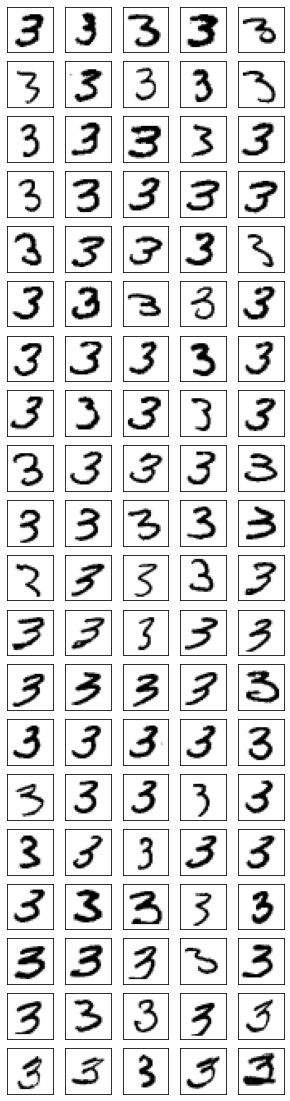

In [166]:
mnist_subplots(X)

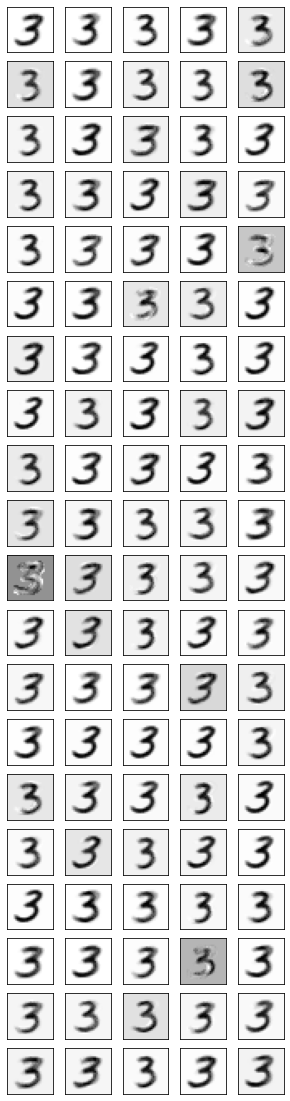

In [167]:
mnist_subplots(L)

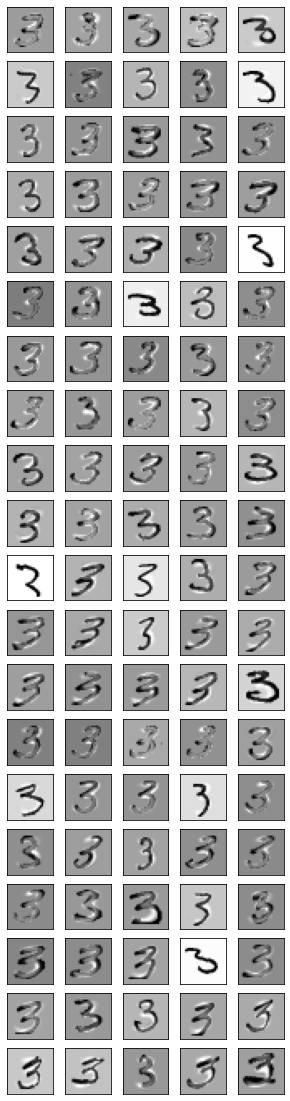

In [168]:
mnist_subplots(S)

In [173]:
print(np.linalg.matrix_rank(X))
print(np.linalg.matrix_rank(L))
print(np.linalg.matrix_rank(S))

100
15
100


#### Next steps
Test PCA on same sample and see how much variance the first 15 components account for

Add progressively more random noise to corrupt X and see how RPCA performs